n this section we will use mock data that is generated from adding Gaussian noise to the function 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
n_repeat = 100       # Number of iterations for computing expectations
n_train = 100        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(311)
estimators = [("Tree", DecisionTreeRegressor()), ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor(), n_estimators=10))]
n_estimators = len(estimators)


def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def plot_f():
    x = np.linspace(-5, 5, 100)
    y = f(x)
    plt.plot(x, y, label="$f(x)$")
    plt.plot(x, f(x) + np.random.normal(0.0, noise, x.shape[0]), '.r', alpha=0.5, label="$y = f(x)+noise$")
    plt.title("$f(x)$")
    plt.legend()


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)
    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

Tree: 0.0214 (error) = 0.0001 (bias^2) + 0.0113 (var) + 0.0099 (noise)
Bagging(Tree): 0.0164 (error) = 0.0001 (bias^2) + 0.0063 (var) + 0.0099 (noise)


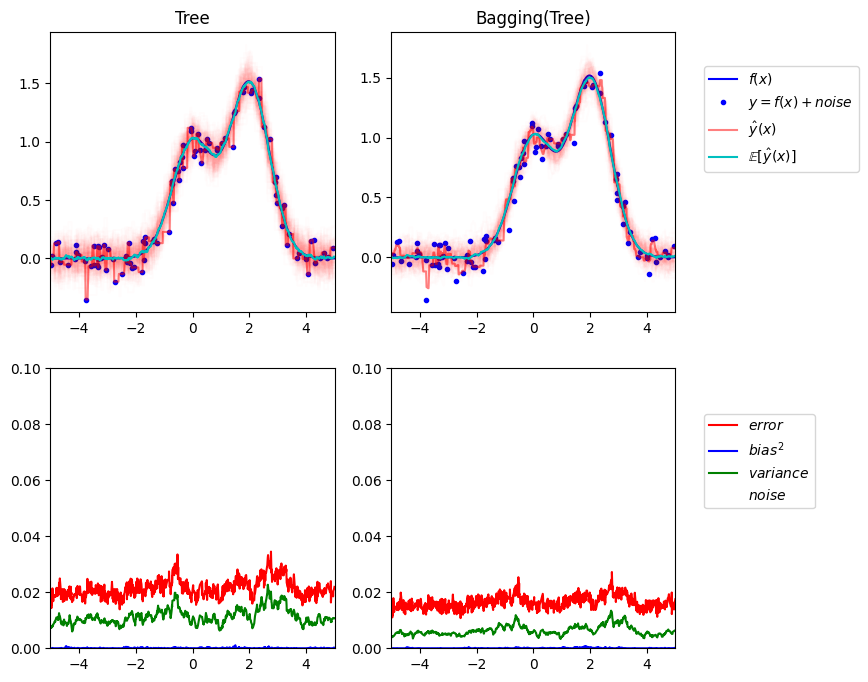

In [2]:
X_train = []
y_train = []
for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)
plt.figure(figsize=(10, 8))
# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i]) 
        # Calling fit() more than once will overwrite what was learned by any previous fit().
        y_predict[:, i] = estimator.predict(X_test)
    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)
    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2
    y_error /= (n_repeat * n_repeat)
    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)
    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) + {3:.4f} (var) + {4:.4f} (noise)".format(name, np.mean(y_error), np.mean(y_bias), np.mean(y_var), np.mean(y_noise)))
    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="$y = f(x)+noise$")
    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$", alpha=0.5)
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.01)
    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E} [\^y(x)]$")
    plt.xlim([-5, 5])
    plt.title(name)
    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))
    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error$")
    plt.plot(X_test, y_bias, "b", label="$bias^2$"),
    plt.plot(X_test, y_var, "g", label="$variance$"),
    plt.plot(X_test, y_noise, "c", label="$noise$", alpha=0.)
    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])
    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))
plt.subplots_adjust(right=.75)

As it is seen in Figure above, bias and noise stay the same in both of the trained models (with and without bagging) while variance is reduced for bagged tree. This behaviour is as expected: bagging technique reduces the variance of the model.